In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, SelectKBest, chi2
import statsmodels.api as sm
import numpy as np

In [100]:
data = pd.read_csv (r'data_clean_4_21.csv')

## Data sources:
USDA Rural-Urban Continuum Codes    
https://www.ers.usda.gov/data-products/rural-urban-continuum-codes.aspx   
US census income and poverty data   
https://www.census.gov/data/tables/2019/demo/income-poverty/p60-266.html   
Covid-19 health system capacity   
https://github.com/covidcaremap/covid19-healthsystemcapacity/tree/master/data       
NY times covid-19 cases/deaths count   
https://github.com/nytimes/covid-19-data   

## Exploratory Analysis

In [101]:
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    for x in unique_list: 
        print (x)

Top 25 counties with most cases and deaths distributed in the following states: 

In [102]:
data.columns

Index(['fips_code', 'date', 'county', 'state.x', 'cases.x', 'deaths.x',
       'State', 'County.Name', 'Staffed.All.Beds', 'Staffed.ICU.Beds',
       'Licensed.All.Beds', 'All.Bed.Occupancy.Rate', 'ICU.Bed.Occupancy.Rate',
       'Population', 'Population..20..', 'Population..65..',
       'Staffed.All.Beds..Per.1000.People.',
       'Staffed.All.Beds..Per.1000.Adults..20...',
       'Staffed.All.Beds..Per.1000.Elderly..65...',
       'Staffed.ICU.Beds..Per.1000.People.',
       'Staffed.ICU.Beds..Per.1000.Adults..20...',
       'Staffed.ICU.Beds..Per.1000.Elderly..65...',
       'Licensed.All.Beds..Per.1000.People.',
       'Licensed.All.Beds..Per.1000.Adults..20...',
       'Licensed.All.Beds..Per.1000.Elderly..65...', 'county_x',
       'staffed_all_beds', 'staffed_icu_beds', 'licensed_all_beds',
       'all_bed_occupancy_rate', 'icu_bed_occupancy_rate', 'population',
       'population_20', 'population_65', 'staffed_all_beds_.per_1000_people.',
       'staffed_all_beds_.per_1000_ad

In [103]:
data1 = data[['cases', 'deaths', 'state', 'county_x']]
top = data1.sort_values(['cases', 'deaths'], ascending=False).head(25)
unique(list(top['state']))

KeyError: "['state', 'cases', 'deaths'] not in index"

Top states with most cases and deaths across all counties:

In [94]:
data1.groupby(['state']).sum().sort_values(['cases', 'deaths'], ascending=False).head(11)

,cases,deaths
state,,
New York,114584.0,4685.0
New Jersey,94820.0,5061.0
Massachusetts,42090.0,2173.0
California,37572.0,1425.0
Pennsylvania,36310.0,1706.0
Illinois,34563.0,1560.0
Michigan,33138.0,2785.0
Florida,28239.0,889.0
Louisiana,24188.0,1386.0


Text(0,0.5,'deathes')

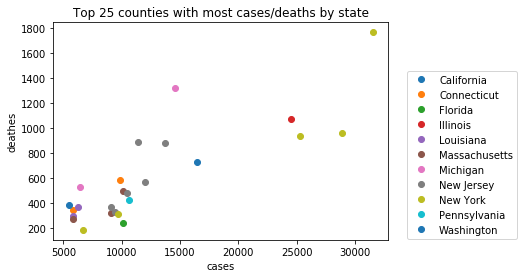

In [96]:
groups = top.groupby("state")
for name, group in groups:
    plt.plot(group["cases"], group["deaths"], marker="o", linestyle="", label=name)
plt.legend(loc='best', bbox_to_anchor=(0.9, 0., 0.5, 0.8))
plt.title('Top 25 counties with most cases/deaths by state')
plt.xlabel('cases')
plt.ylabel('deathes')

## Methods
1. Model capability using multiple linear regression.  
2. Apply multivariate bootstrap techniques with hypothesis testing for model selection.  
3. Clustering (hierarchical clustering) for capability classification based on US regions. 

## 1. Regression
Multiple linear regression was conducted on the following variables: population_65+, population, licensed_all_beds, staffed_all_beds, population_20+, and licensed_all_beds_per_1000_people. Variables were selected after running forward selection and backward eliminiation. 

In [97]:
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [99]:
X = data.drop(['cases', 'deaths', 'fips_code', 'county_x', 'State.x', 'County_Name', 'State.y', 'Area_name'], axis = 1)
Y = data['cases']
#forward_selection(X, Y)
X

,staffed_all_beds,staffed_icu_beds,licensed_all_beds,all_bed_occupancy_rate,icu_bed_occupancy_rate,population,population_20,population_65,staffed_all_beds_.per_1000_people.,staffed_all_beds_.per_1000_adults_20..,...,licensed_all_beds_.per_1000_adults_20..,licensed_all_beds_.per_1000_elderly_65..,state,Population_2010,RUCC_2013,Description,Rural.urban_Continuum_Code_2013,Urban_Influence_Code_2013,peopleinpoverty2018,medianhouseholdincome
0,55,6,85,0.62,0.53,55601,41177,8653,0.989,1.336,...,2.064,9.823,Alabama,54571.0,2.0,"Metro - Counties in metro areas of 250,000 to ...",2.0,2.0,"7,587","59,338"
1,362,51,386,0.64,0.65,218022,166352,44571,1.660,2.176,...,2.320,8.660,Alabama,182265.0,3.0,Metro - Counties in metro areas of fewer than ...,3.0,2.0,"21,069","57,588"
2,30,5,74,0.43,0.42,24881,19189,4832,1.206,1.563,...,3.856,15.315,Alabama,27457.0,6.0,"Nonmetro - Urban population of 2,500 to 19,999...",6.0,6.0,"6,788","34,382"
3,25,0,35,0.37,0.00,22400,17348,3690,1.116,1.441,...,2.018,9.485,Alabama,22915.0,1.0,Metro - Counties in metro areas of 1 million p...,1.0,1.0,"4,400","46,064"
4,25,6,25,0.50,0.34,57840,43175,10548,0.432,0.579,...,0.579,2.370,Alabama,57322.0,1.0,Metro - Counties in metro areas of 1 million p...,1.0,1.0,"7,527","50,412"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,2284,254,2606,0.60,0.75,0,0,0,0.000,0.000,...,0.000,0.000,NaN,395326.0,1.0,Metro - Counties in metro areas of 1 million p...,NaN,NaN,NaN,NaN
2529,7,0,7,0.44,0.00,0,0,0,0.000,0.000,...,0.000,0.000,NaN,33149.0,2.0,"Metro - Counties in metro areas of 250,000 to ...",NaN,NaN,NaN,NaN
2530,130,6,130,0.26,0.62,0,0,0,0.000,0.000,...,0.000,0.000,NaN,59662.0,1.0,Metro - Counties in metro areas of 1 million p...,NaN,NaN,NaN,NaN
2531,0,0,0,0.00,0.00,0,0,0,0.000,0.000,...,0.000,0.000,NaN,9301.0,7.0,"Nonmetro - Urban population of 2,500 to 19,999...",NaN,NaN,NaN,NaN
